# Full revision analysis

## List of work to be performed:
1. Supplementary figure showing incorrect inform tumor segmentation and NKT cells 
2. Supplementary figure with zoom-in images of individual cells from inForm and TME-Analyzer in an image with high disagreement 
3. Incorporation of DeepCell into TME-Analyzer 
4. Reorganize the MonteCarlo trials 
5. Supplementary table 6 with full ranking of parameters and discovery/validation p values if top n parameters were used instead. 
6. Generate forest plot for 4E 
7. Build classifier based on train-test split of discovery cohort. Try 16-47, 32-31, 47-16 splits. 
8. ? It is significant amount of work, but since both reviewers mention is, I can train a random forest on the original dataset and report it ? 

## 6. Generate forest plot for 4E 

Original data is at:

"E:\Moved from E\TME-Analyzer_the_manuscript\20211129_TME-Analyzer\data_analysis\reproduction_of_old_analysis\20230614_Marcel\multivariate\summary.xlsx"

Forest plots are at:

"E:\Moved from E\TME-Analyzer_the_manuscript\20211129_TME-Analyzer\data_analysis\reproduction_of_old_analysis\20230103_HR"

Let's start by recreating the original data with the new classifier

In [24]:

from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter, KaplanMeierFitter
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from lifelines.statistics import logrank_test

main_folder = 'E:/Moved from E/TME-Analyzer_the_manuscript/20211129_TME-Analyzer/'
input_folder = main_folder + '/ML/combination/'
input_folder = "E:/TME-Analyzer-large-files-from-desktop-folder/20231207_revision_files/Task5/"
output_folder = "E:/TME-Analyzer-large-files-from-desktop-folder/20231207_revision_files/Task6/"
auto_density_file = main_folder + '/data_analysis/output/validation_densities.xls'
auto_score_file = main_folder + '/data_analysis/output/normalized_distances.xls'
keren_density_file = main_folder + '/analysis_keren_et_al/validation/validation_densities.xls'
keren_score_file = main_folder + '/analysis_keren_et_al/validation/validation_scores.xls'
auto_clinical_file = 'E:/Moved from E/Dora effector/COX_analysis/survival without HER2 samples_mod.txt'
keren_clinical_file = 'E:/Desktop_backup_20231031/Desktop/TME-Analyzer_the_manuscript/images from keren et al/article_data_tables/1-s2.0-S0092867418311000-mmc2_mod.xlsx'

clinical_data_raw = pd.read_excel(keren_clinical_file, engine='openpyxl')
clinical_data = pd.DataFrame(index = ['patient' + str(i+1) for i in range(41) if i not in [21,37]],columns = ['os','osi','TIL_score'])

multi_COX = pd.DataFrame(index = [np.array(['discovery','discovery','discovery','validation','validation','validation']),
                                  np.array(['Inflammation status','T cell density','classifier','Inflammation status','T cell density','classifier'])],
                         columns = [np.array(['univariate','univariate','multivariate','multivariate']),
                                    np.array(['HR (95% CI for HR)','p-value','HR (95% CI for HR)','p-value'])])

for i in range(41):
    if i in [21,37]:
        continue
    pat_n = i+1
    clinical_data.loc['patient' + str(i+1),'os'] = clinical_data_raw[clinical_data_raw['InternalId']==pat_n]['Survival_days_capped*'].to_numpy()[0]
    clinical_data.loc['patient' + str(i+1),'osi'] = clinical_data_raw[clinical_data_raw['InternalId']==pat_n]['Censored'].to_numpy()[0] == 0
    clinical_data.loc['patient' + str(i+1),'TIL_score'] = clinical_data_raw[clinical_data_raw['InternalId']==pat_n]['TIL_score'].to_numpy()[0]

validation_multi = pd.DataFrame(index = clinical_data.index, columns = ['os','osi','TIL_score','stromal_TIL','classifier'])
validation_multi[['os','osi','TIL_score']] = clinical_data


data_frame = pd.read_csv(keren_density_file,sep='\t')
data_frame = data_frame.set_index(data_frame.keys()[0])
data_frame_orig = data_frame.copy()

pd_frame = pd.read_csv(keren_score_file,sep='\t')
pd_frame = pd_frame.set_index(pd_frame.keys()[0])

distance_index = ['patient' + i[i.find('Point')+5:i.find('.')] for i in pd_frame['sample id']]
distance_frame = pd_frame.iloc[:,1:]
# distance_frame = 1/distance_frame
# distance_frame[distance_frame.isna()] = 0
distance_frame.index = distance_index
data_frame = pd.concat((data_frame_orig,distance_frame),axis=1)

## in_center_classifier_10_validated_keys_validation

classifier_to_test = 'in_center_classifier_10_validated_keys'

px_size_dora = 0.4999
im_size_dora = 1352*1008
im_size_keren = 2048*2048
# classifier_frame = pd.read_excel(input_folder + classifier_to_test + '.xls')
try:
    classifier_frame = pd.read_excel(input_folder + classifier_to_test + '.xls')
except:
    classifier_frame = pd.read_csv(input_folder + classifier_to_test + '.xls',sep='\t')
classifier_frame_new = pd.DataFrame(classifier_frame[['mean (good prognosis)', 'mean (bad prognosis)']])
classifier_frame_new.index = classifier_frame['Unnamed: 0']#,columns = ['mean (good prognosis)', 'mean (bad prognosis)'])

for i in classifier_frame_new.index:
    if 'area' in i:
        classifier_frame_new.loc[i] = classifier_frame_new.loc[i]*px_size_dora*px_size_dora#/im_size_dora*im_size_keren
    elif 'density' in i:
        classifier_frame_new.loc[i] = classifier_frame_new.loc[i]/px_size_dora/px_size_dora

new_index = []
for i in classifier_frame_new.index:
    if 'found' in i:
        new_index.append(i[:i.find('found')-1])
    else:
        new_index.append(i[:i[::-1].find('ni')*-1-3])
classifier_frame_new.index = new_index

data_frame_truncated = data_frame.loc[clinical_data.index,new_index]


all_tot_d = np.zeros((data_frame_truncated.shape[0],2))
for i in range(data_frame_truncated.shape[0]):
    temp_data = data_frame_truncated.iloc[i,:].copy().to_numpy()
    temp1 = classifier_frame_new['mean (bad prognosis)'].to_numpy()[temp_data==temp_data]
    temp2 = classifier_frame_new['mean (good prognosis)'].to_numpy()[temp_data==temp_data]
    temp_data = temp_data[temp_data == temp_data]
    all_tot_d[i,1] = np.sum(((temp_data - temp1)/(temp2-temp1))<0.5)
    all_tot_d[i,0] = np.sum(((temp_data - temp2)/(temp1-temp2))<0.5)
    all_tot_d[i] = all_tot_d[i] / np.sum(all_tot_d[i])


validation_multi.loc[data_frame_truncated.index,'classifier'] = all_tot_d[:,0]>np.median(all_tot_d[:,0])

prognostic_densities = ['density of CD3 CD8 in Stroma','density of CD3 in Stroma']

validation_multi_fill = validation_multi.copy()
validation_multi_fill["stromal_TIL"] = data_frame.loc[validation_multi_fill.index,prognostic_densities].sum(axis=1)
validation_multi_fill["stromal_TIL"] = validation_multi_fill["stromal_TIL"]>validation_multi_fill["stromal_TIL"].median()

validation_multi_fill["TIL_score"].fillna(validation_multi_fill["TIL_score"].mean(), inplace = True)
validation_multi_fill["TIL_score"] = validation_multi_fill["TIL_score"]>validation_multi_fill["TIL_score"].median()
cph = CoxPHFitter()

rename_lookup = {'TIL_score': 'Inflammation status',
                 'stromal_TIL': 'T cell density',
                 'classifier': 'classifier'}
cph.fit(validation_multi_fill.dropna(), 'os', 'osi')



FP_cohort = []
FP_cutoff = []
FP_pvalue = []
FP_HR = []
FP_CI_low = []
FP_CI_high = []
for n_i, i in enumerate(validation_multi.keys()[2:]):
    multi_COX.loc['validation',rename_lookup[i]]['multivariate','HR (95% CI for HR)'] = str('%.2f' % cph.summary.to_numpy()[n_i][1]) + ' (' + str('%.2f' % cph.summary.to_numpy()[n_i][5]) + '-' + str('%.2f' % cph.summary.to_numpy()[n_i][6]) + ')'
    multi_COX.loc['validation',rename_lookup[i]]['multivariate','p-value'] = str('%.4f' % cph.summary.to_numpy()[n_i][9])
    

    FP_cohort.append('validation-multivariate')
    FP_cutoff.append(rename_lookup[i])
    FP_pvalue.append(str('%.4f' % cph.summary.to_numpy()[n_i][9]))
    FP_HR.append(cph.summary.to_numpy()[n_i][1])
    FP_CI_low.append(cph.summary.to_numpy()[n_i][5])
    FP_CI_high.append(cph.summary.to_numpy()[n_i][6])

validation_multi_fill = validation_multi.copy()
validation_multi_fill["stromal_TIL"] = data_frame.loc[validation_multi_fill.index,prognostic_densities].sum(axis=1)
validation_multi_fill["stromal_TIL"] = validation_multi_fill["stromal_TIL"]>validation_multi_fill["stromal_TIL"].median()
validation_multi_fill["TIL_score"] = validation_multi_fill["TIL_score"].dropna()>validation_multi_fill["TIL_score"].median()

for i in validation_multi.keys()[2:]:
    cph = CoxPHFitter()
    cph.fit(validation_multi_fill[['os','osi',i]].dropna(), 'os', 'osi')
    # cph.print_summary()
    multi_COX.loc['validation',rename_lookup[i]]['univariate','HR (95% CI for HR)'] = str('%.2f' % cph.summary.to_numpy()[0][1]) + ' (' + str('%.2f' % cph.summary.to_numpy()[0][5]) + '-' + str('%.2f' % cph.summary.to_numpy()[0][6]) + ')'
    multi_COX.loc['validation',rename_lookup[i]]['univariate','p-value'] = str('%.4f' % cph.summary.to_numpy()[0][9])
    FP_cohort.append('validation-univariate')
    FP_cutoff.append(rename_lookup[i])
    FP_pvalue.append(str('%.4f' % cph.summary.to_numpy()[0][9]))
    FP_HR.append(cph.summary.to_numpy()[0][1])
    FP_CI_low.append(cph.summary.to_numpy()[0][5])
    FP_CI_high.append(cph.summary.to_numpy()[0][6])


    T1 = validation_multi_fill['os'][validation_multi_fill[i] == True]
    E1 = validation_multi_fill['osi'][validation_multi_fill[i] == True]
    T2 = validation_multi_fill['os'][validation_multi_fill[i] == False]
    E2 = validation_multi_fill['osi'][validation_multi_fill[i] == False]
    plt.figure()
    kmf = KaplanMeierFitter()
    kmf.fit(T1[T1==T1]/365,E1[T1==T1], label= rename_lookup[i] + ' high, n=' + str(len(T1[T1==T1])))
    a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:blue')

    temp = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    kmf.fit(T2[T2==T2]/365,E2[T2==T2], label= rename_lookup[i] + ' low, n=' + str(len(T2[T2==T2])) + ', p = ' + format(temp.p_value, '.6f'))
    a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:orange')
    a1.set_ylabel('overall survival')
    a1.set_ylim(0,1.05)
    a1.set_xlim(-0.2,15.05)
    a1.set_xlabel('years')
    plt.savefig(output_folder + i + '_validation.png')
    plt.close('all')


T1_1 = T1[(T1>5*365)|(E1==1)]
T2_1 = T2[(T2>5*365)|(E2==1)]
T1_2 = T1[(T1>10*365)|(E1==1)]
T2_2 = T2[(T2>10*365)|(E2==1)]
print('validation', len(T1), len(T2),
      np.sum(T1_1>(365*5))/len(T1_1), np.sum(T2_1>(365*5))/len(T2_1),
      np.sum(T1_2>(365*10))/len(T1_2), np.sum(T2_2>(365*10))/len(T2_2))



classifier_to_test = 'in_center_classifier_10_validated_keys'
data_frame = pd.read_csv(auto_density_file,sep='\t')
clinical_data = pd.read_csv(auto_clinical_file,sep='\t')
clinical_data.index = clinical_data['sample']
data_frame.index = data_frame.iloc[:,0]
px_size_dora = 0.4999
try:
    classifier_frame = pd.read_excel(input_folder + classifier_to_test + '.xls')
except:
    classifier_frame = pd.read_csv(input_folder + classifier_to_test + '.xls',sep='\t')

# classifier_frame = pd.read_excel(input_folder + classifier_to_test + '.xls')

keys_to_keep = [1,1,1]
for i in data_frame.keys()[3:]:
    if 'auto' in i:
        keys_to_keep.append(1)
    else:
        keys_to_keep.append(0)

data_frame = data_frame.iloc[:,np.array(keys_to_keep)>0]

MSI_names = data_frame.iloc[:,0].to_numpy()

patients = []
for MSI in MSI_names:
    if MSI[:MSI.find(' ')] < MSI[:MSI.find('_')]:
        patients.append(MSI[:MSI.find(' ')])
    else:
        patients.append(MSI[:MSI.find('_')])

patients = np.unique(patients)



patients=list(patients)

for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    if (np.sum(to_average['location'] == 'border') <3) & (np.sum(to_average['location'] == 'center') <3):
        patients.pop(patients.index(patient_index))

patients = np.array(patients)

# note ['FG-87-10839 excl_[48581,14771]_M2', 'IC-90-08870 infl_[41660,10828]_M2'] are dublicates
discovery_distances = pd.read_csv(auto_score_file,sep='\t')
# discovery_ids = [i[:i.find(']')+1] for i in discovery_distances['sample id']]
discovery_ids = [i[:i.find('_component')] for i in discovery_distances['sample id']]
discovery_distances.index = discovery_ids
discovery_distances = discovery_distances.iloc[:,2:]
data_frame = pd.concat((data_frame,discovery_distances),axis=1)

patient_cols = [i + ' in ' + j for i in data_frame.keys()[3:] for j in ['border','center','all']]


patient_frame = pd.DataFrame(index = patients, columns = patient_cols)


for patient_index in patients:
    MSI_of_interest = []
    for MSI in MSI_names:
        if patient_index in MSI:
            MSI_of_interest.append(MSI)
    to_average = data_frame.loc[MSI_of_interest]
    for col_name in patient_cols:
        if 'in all' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[col_name[:col_name.find(' in all')]]))
        elif 'in border' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
        elif 'in center' in col_name:
            patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'center'][col_name[:col_name.find(' in center')]]))

combined_data = clinical_data.loc[patient_frame.index][['mfsi','mfs','osi','os','dfsi','dfs']]
combined_data = pd.merge(combined_data,patient_frame, left_index=True, right_index=True)
combined_data = combined_data[combined_data['mfs'] == combined_data['mfs']]
combined_data['mfsi'] = combined_data['mfsi'] == 1
combined_data['osi'] = combined_data['osi'] == 1

significant_keys_gated = [i.replace('TME','auto') for i in classifier_frame.iloc[:,0]]


all_tot_d = np.zeros((combined_data.shape[0],2))
for i in range(combined_data.shape[0]):
    temp_data = combined_data.iloc[i,:][significant_keys_gated].copy().to_numpy()
    temp1 = classifier_frame['mean (bad prognosis)'].to_numpy()[temp_data==temp_data]
    temp2 = classifier_frame['mean (good prognosis)'].to_numpy()[temp_data==temp_data]
    temp_data = temp_data[temp_data == temp_data]
    all_tot_d[i,1] = np.sum(((temp_data - temp1)/(temp2-temp1))<0.5)
    all_tot_d[i,0] = np.sum(((temp_data - temp2)/(temp1-temp2))<0.5)
    all_tot_d[i] = all_tot_d[i] / np.sum(all_tot_d[i])

discovery_multi = pd.DataFrame(index=combined_data.index,columns = ['os','osi','TIL_score','stromal_TIL','classifier'])
discovery_multi[['os','osi']] = clinical_data.loc[combined_data.index,['os','osi']]
discovery_multi['TIL_score'] = clinical_data.loc[combined_data.index,'score vectra'] == 'inflamed'

prognostic_densities = ['density of CD3 CD8 in Stroma found by auto analysis in center','density of CD3 in Stroma found by auto analysis in center']

discovery_multi.loc[combined_data.index,'classifier'] = all_tot_d[:,0]>np.median(all_tot_d[:,0])

discovery_multi = discovery_multi.copy()
discovery_multi["stromal_TIL"] = combined_data.loc[discovery_multi.index,prognostic_densities].sum(axis=1)
discovery_multi["stromal_TIL"] = discovery_multi["stromal_TIL"]>discovery_multi["stromal_TIL"].median()
cph = CoxPHFitter()

cph.fit(discovery_multi, 'os', 'osi')

for n_i, i in enumerate(validation_multi.keys()[2:]):
    multi_COX.loc['discovery',rename_lookup[i]]['multivariate','HR (95% CI for HR)'] = str('%.2f' % cph.summary.to_numpy()[n_i][1]) + ' (' + str('%.2f' % cph.summary.to_numpy()[n_i][5]) + '-' + str('%.2f' % cph.summary.to_numpy()[n_i][6]) + ')'
    multi_COX.loc['discovery',rename_lookup[i]]['multivariate','p-value'] = str('%.4f' % cph.summary.to_numpy()[n_i][9])
    FP_cohort.append('discovery-multivariate')
    FP_cutoff.append(rename_lookup[i])
    FP_pvalue.append(str('%.4f' % cph.summary.to_numpy()[n_i][9]))
    FP_HR.append(cph.summary.to_numpy()[n_i][1])
    FP_CI_low.append(cph.summary.to_numpy()[n_i][5])
    FP_CI_high.append(cph.summary.to_numpy()[n_i][6])


rename_lookup = {'TIL_score': 'Inflammation status',
                 'stromal_TIL': 'T cell density',
                 'classifier': 'classifier'}
for i in validation_multi.keys()[2:]:
    cph = CoxPHFitter()
    cph.fit(discovery_multi[['os','osi',i]].dropna(), 'os', 'osi')
    # cph.print_summary()
    multi_COX.loc['discovery',rename_lookup[i]]['univariate','HR (95% CI for HR)'] = str('%.2f' % cph.summary.to_numpy()[0][1]) + ' (' + str('%.2f' % cph.summary.to_numpy()[0][5]) + '-' + str('%.2f' % cph.summary.to_numpy()[0][6]) + ')'
    multi_COX.loc['discovery',rename_lookup[i]]['univariate','p-value'] = str('%.4f' % cph.summary.to_numpy()[0][9])
    FP_cohort.append('discovery-univariate')
    FP_cutoff.append(rename_lookup[i])
    FP_pvalue.append(str('%.4f' % cph.summary.to_numpy()[0][9]))
    FP_HR.append(cph.summary.to_numpy()[0][1])
    FP_CI_low.append(cph.summary.to_numpy()[0][5])
    FP_CI_high.append(cph.summary.to_numpy()[0][6])

    T1 = discovery_multi['os'][discovery_multi[i] == True]
    E1 = discovery_multi['osi'][discovery_multi[i] == True]
    T2 = discovery_multi['os'][discovery_multi[i] == False]
    E2 = discovery_multi['osi'][discovery_multi[i] == False]
    plt.figure()
    kmf = KaplanMeierFitter()
    kmf.fit(T1[T1==T1]/12,E1[T1==T1], label= rename_lookup[i] + ' high, n=' + str(len(T1[T1==T1])))
    a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:blue')

    temp = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    kmf.fit(T2[T2==T2]/12,E2[T2==T2], label= rename_lookup[i] + ' low, n=' + str(len(T2[T2==T2])) + ', p = ' + format(temp.p_value, '.6f'))
    a1 = kmf.plot(ci_show=False, show_censors=True,color='tab:orange')
    a1.set_ylabel('overall survival')
    a1.set_ylim(0,1.05)
    a1.set_xlim(-0.2,15.05)
    a1.set_xlabel('years')
    plt.savefig(output_folder + i + '_discovery.png')
    plt.close('all')


# print('discovery', len(T1), len(T2),
#       np.sum(T1>(12*5))/len(T1), np.sum(T2>(12*5))/len(T2),
#       np.sum(T1>(12*10))/len(T1), np.sum(T2>(12*10))/len(T2))
T1_1 = T1[(T1>60)|(E1==1)]
T2_1 = T2[(T2>60)|(E2==1)]
# print('discovery', len(T1_1), len(T2_1),
#       np.sum(T1_1>(12*5))/len(T1_1), np.sum(T2_1>(12*5))/len(T2_1),
#       np.sum(T1_1>(12*10))/len(T1_1), np.sum(T2_1>(12*10))/len(T2_1))
T1_2 = T1[(T1>120)|(E1==1)]
T2_2 = T2[(T2>120)|(E2==1)]
# print('discovery', len(T1_2), len(T2_2),
#       np.sum(T1_2>(12*5))/len(T1_2), np.sum(T2_2>(12*5))/len(T2_2),
#       np.sum(T1_2>(12*10))/len(T1_2), np.sum(T2_2>(12*10))/len(T2_2))
print('discovery', len(T1), len(T2),
      np.sum(T1_1>(12*5))/len(T1_1), np.sum(T2_1>(12*5))/len(T2_1),
      np.sum(T1_2>(12*10))/len(T1_2), np.sum(T2_2>(12*10))/len(T2_2))



multi_COX.to_excel(output_folder + 'summary.xlsx')


c:\Users\balci\visual_code\TME-Analyzer\TME_Analyzer-resubmission\.venv\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\Users\balci\visual_code\TME-Analyzer\TME_Analyzer-resubmission\.venv\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\Users\balci\visual_code\TME-Analyzer\TME_Analyzer-resubmission\.venv\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do con

validation 15 24 1.0 0.5217391304347826 0.9090909090909091 0.13333333333333333


C:\Users\balci\AppData\Local\Temp\ipykernel_16560\1384828384.py:254: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'border'][col_name[:col_name.find(' in border')]]))
C:\Users\balci\AppData\Local\Temp\ipykernel_16560\1384828384.py:256: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[to_average['location'] == 'center'][col_name[:col_name.find(' in center')]]))
C:\Users\balci\AppData\Local\Temp\ipykernel_16560\1384828384.py:252: RuntimeWarning: Mean of empty slice
  patient_frame.loc[patient_index][col_name] = np.nanmean(np.float32(to_average[col_name[:col_name.find(' in all')]]))


discovery 31 32 1.0 0.5806451612903226 0.9444444444444444 0.25925925925925924


Now, let's make a forest plot

start with defining forest plot in python

C:\Users\balci\AppData\Local\Temp\ipykernel_16560\1754915264.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sort_order'] = np.arange(data.shape[0])[::-1]


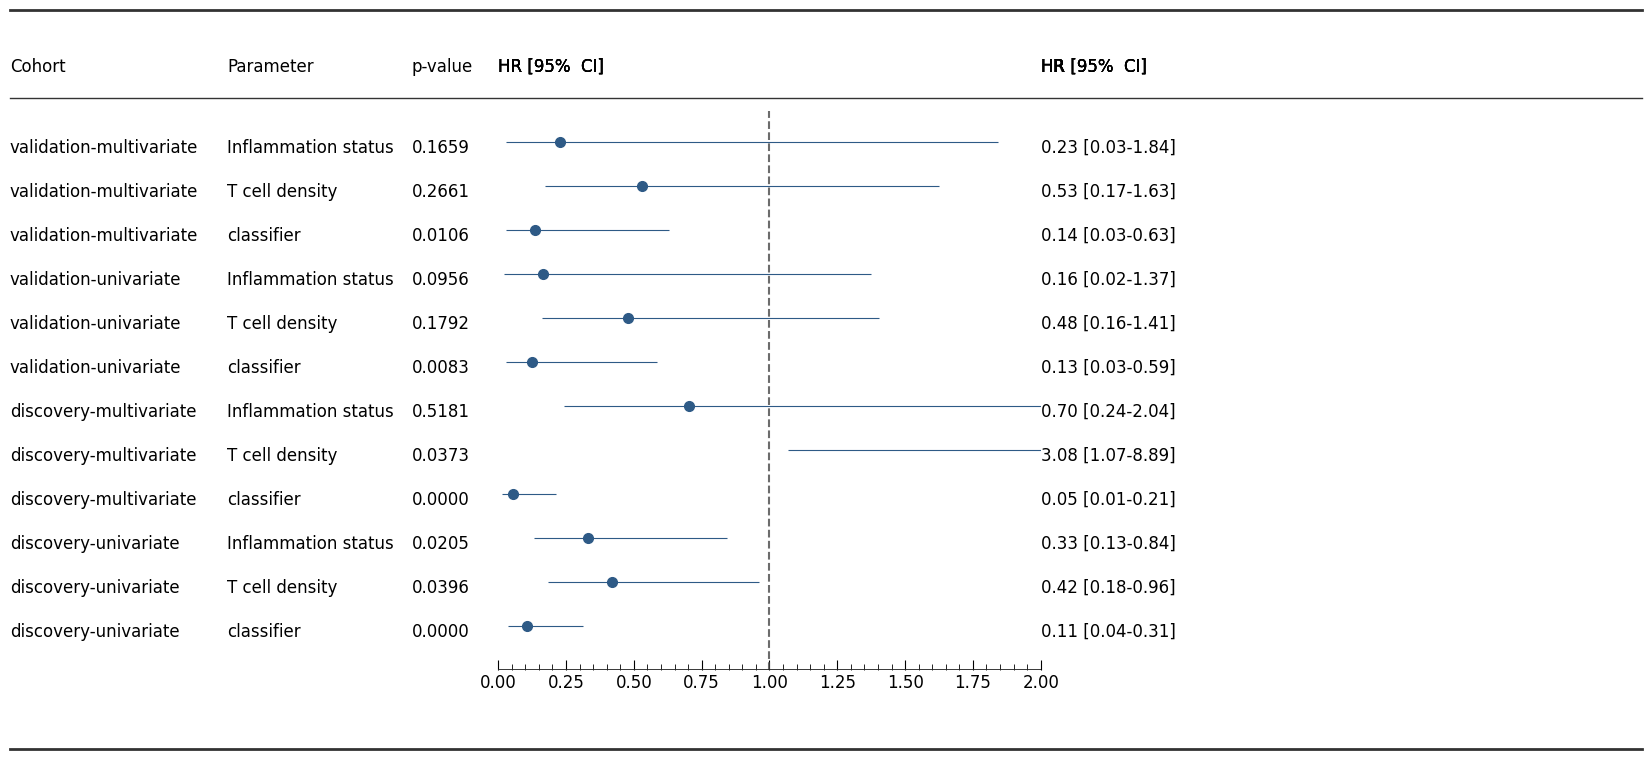

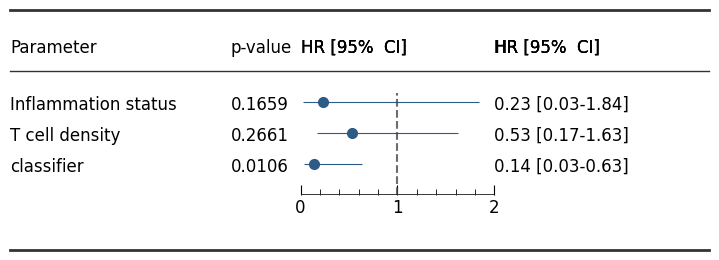

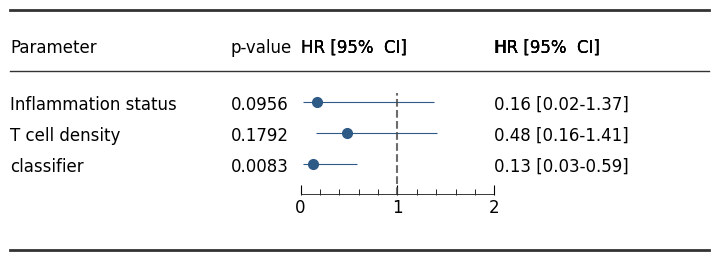

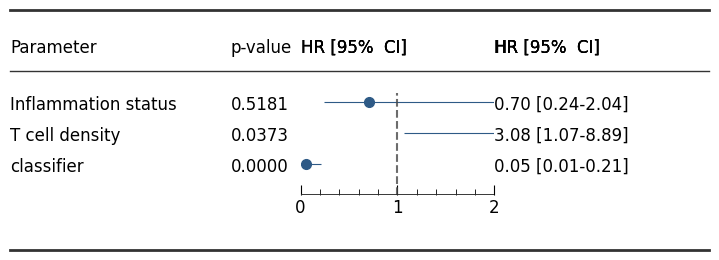

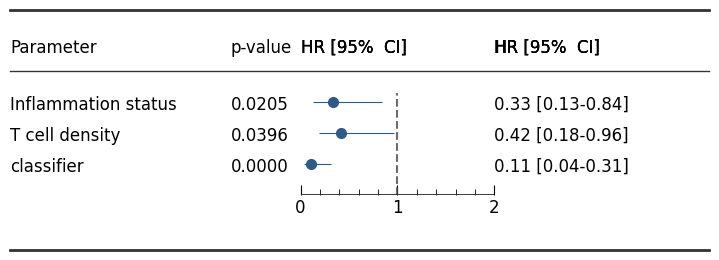

In [101]:

def check_axes(fig, ax, fig_shape=None):
    if all([x is None for x in [fig, ax]]):
        fig_shape = (8, 19) if fig_shape is None else None
        fig, ax = plt.subplots(figsize=fig_shape)

    return fig, ax


def get_xlim(ax):
    xmin, xmax = ax.get_xaxis().get_view_interval()

    return xmin, xmax


def get_ylim(ax):
    ymin, ymax = ax.get_yaxis().get_view_interval()

    return ymin, ymax


def save_fig(fig, file_name, save_type='pdf', dpi=500):
    if save_type == 'pdf':
        fig.savefig('{}.pdf'.format(file_name), transparent=False, dpi=dpi,
                    bbox_inches='tight')

    elif save_type == 'tiff':
        fig.savefig('{}.tiff'.format(file_name), transparent=False, dpi=dpi,
                    bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
    else:
        raise ValueError('Figure type not supported')

def check_data(data):
    assert isinstance(data, pd.DataFrame), 'Please supply data as Pandas DataFrame'

    data['sort_order'] = np.arange(data.shape[0])[::-1]
    return data


def forest_plot(data, auc_col, se_col, to_annotate=None, subset_col=None, fig=None, ax=None, add_legend=True,
                legend_loc='upper right', hbar_lim=None, xlim=None, fig_shape=None, anot_base=0.15,
                annot_offset=13, annot_scaler=0.01, add_ci=True, auc_label=None, fargs=None):
    """
    Basic forest plots for meta analyses
    Parameters
    ----------
    data: pandas DataFrame
        contains all columns to be annotated, AUCs and standard errors
    auc_col: str
        named of column containing AUC values
    se_col: str
        name of column containing standard errors
    to_annotate: list of str, default None
        column names for information to annotation on the left of the plot
    subset_col: str, default None
        name of column for splitting data by marker type in plot
    fig: matplotlib figure, default None
        use if matplotlib figure/axes have already been created
    ax: matplotlib axes, default None
        use if matplotlib figure/axes have already been created
    add_legend: bool, default True
        add a legend
    legend_loc: str, default 'upper right'
        location of legend
    hbar_lim: tuple or list, default None
        x-axis limits for the header/tail of table
    xlim: tuple or list, default None
        x-axis limits for plotting AUC and error bars
    fig_shape: tuple, default None
        figure size to use if you want to overwrite the default shape
    anot_base: float, default 0.15
        minimum distance between all columns, regardless of column width
    annot_offset: float, default 13
        estimate of average number of characters per column. Adjust up or down accordingly
    annot_scaler: float, default 0.01
        estimate of the amount by extra/reduced space to give column widths that deviate from annot_offset
    add_ci: bool, default True
        Annotate CI after AUC
    auc_label: str or None, default None
        Label for the forest plot section
    fargs: dict, default None
         kwargs for fontsizes
    Returns
    -------
    fig, ax: matplotlib figure and axes objects
    """
    data = check_data(data)
    fig, ax = check_axes(fig, ax, fig_shape)

    # plot auc and 95% CI
    ax = plot_auc(data, ax, auc_col, se_col, subset_col=subset_col, add_legend=add_legend, legend_loc=legend_loc,
                  xlim=xlim, auc_label=auc_label)

    # add all columns in to_annotate as text
    if to_annotate is not None:
        ax = annotate_columns(data, to_annotate, auc_col, se_col, ax, anot_base=anot_base, annot_offset=annot_offset,
                              annot_scaler=annot_scaler, hbar_lim=hbar_lim, add_ci=add_ci, auc_label=auc_label,
                              fargs=fargs)

    return fig, ax


def parse_auc(data, row, auc, se_col, add_ci=True):
    auc = float(auc)
    if add_ci:
        if type(se_col) == str:
            auc = '{:.2f} [{:.2f}-{:.2f}]'.format(auc, auc - (1.96 * float(data.iloc[row, :][se_col])),
                                                  auc + (1.96 * float(data.iloc[row, :][se_col])))
        if type(se_col) == list:
            auc = '{:.2f} [{:.2f}-{:.2f}]'.format(auc, auc - float(data.iloc[row, :][se_col[0]]),
                                                  auc + float(data.iloc[row, :][se_col[1]]))
    else:
        auc = '{:.2f}'.format(auc)

    return auc


def annotate_columns(data, to_annotate, auc_col, se_col, ax, anot_base=0.15, annot_offset=13, annot_scaler=0.01,
                     y_offset=0.25, hbar_lim=None, add_ci=True, auc_label=None, fargs=None):
    xmin, xmax = get_xlim(ax)
    fargs = {'fontsize': 12, 'fontfamily': 'sans-serif', 'clip_on': False} if fargs is None else fargs
    to_annotate = [to_annotate] if isinstance(to_annotate, str) else to_annotate
    assert isinstance(to_annotate, list), 'supply annotation column names as a list of strings'
    to_annotate = to_annotate[::-1]
    column_offsets = []
    annotations = []

    for i, txt in enumerate(np.arange(data.shape[0])):
        xiter = xmin  # moves column annotation outward from plot
        for j, column in enumerate(to_annotate):
            max_len = max(data[column].astype(str).str.len().max(), len(column))  # gets width of a column in characters
            col_shift = anot_base + ((max_len-annot_offset)*annot_scaler)
            if j != 0:
                xiter -= col_shift  # distance away from previous shifted proportional to number of characters
            s = data.iloc[txt, :][column]
            if isinstance(s, (float, np.float)) and np.isnan(s):
                continue
            s = parse_auc(data, txt, s, se_col, add_ci) if column == auc_col else s
            x = xmax if column == auc_col else xiter
            y = data.iloc[txt, :]['sort_order'] - y_offset
            annotations.append(ax.text(x=x, y=y, s=s, **fargs))
            if i == 0:
                auc_label = 'AUC' if auc_label is None else auc_label
                annotations.append(ax.text(x=x, y=data.shape[0]+0.6, s=column, **fargs))
                if add_ci:
                    __ = [annotations.append(ax.text(x=aucx, y=data.shape[0]+0.6, s=auc_label + ' [95%  CI]', **fargs))
                          for aucx in [xmin, xmax]]
                else:
                    __ = [annotations.append(ax.text(x=aucx, y=data.shape[0]+0.6, s=auc_label, **fargs))
                          for aucx in [xmin, xmax]]
                column_offsets.append(col_shift)

    bars = []
    annotations = [a.get_position()[0] for a in annotations]
    if hbar_lim is None:
        #hbar_xmin = 0 - xmin - np.sum(column_offsets) + column_offsets[0]
        #hbar_xmax = 1.22
        if add_ci:
            max_bar = np.max(annotations) if auc_label is None else np.max(annotations) + 0.009 * len(auc_label + ' [95%  CI]')
        else:
            max_bar = np.max(annotations) if auc_label is None else np.max(annotations) + 0.01 * len(auc_label)
        hbar_xmin, hbar_xmax = np.min(annotations), max_bar

    else:
        hbar_xmin, hbar_xmax = hbar_lim

    bargs = {'c': '#333333', 'linestyle': '-'}
    for hbar_ypos, line_width in zip([data.shape[0], data.shape[0]+2, -2.8], [1, 2, 2]):
        bars.append(ax.axhline(y=hbar_ypos, xmin=hbar_xmin, xmax=hbar_xmax*2, linewidth=line_width, **bargs))
    _ = [b.set_clip_on(False) for b in bars]
    _ = [b.set_transform(ax.transData) for b in bars]

    return ax


def plot_auc(data, ax, auc_col, se_col, subset_col=None, colour='#2E5A86', add_vline=True, add_legend=True,
             legend_loc='upper right', xlim=None, auc_label=None):
    if type(se_col) == str:
        se_mod = 1.96
    elif type(se_col) == list:
        se_mod = 1
    if subset_col is not None:
        subsets = data[subset_col].unique().tolist() if subset_col in data.columns else None
    else:
        subsets = None

    if subsets is not None:
        markers = ['o', 's', '^', 'v', 'X', 'P', 'p'][:len(subsets)]
        assert len(markers) == len(subsets), 'More subsets than markers - overwrite marker list'

        for s, m in zip(subsets, markers):
            ax.errorbar(data.loc[data[subset_col] == s, auc_col].to_numpy(dtype='float'),
                        data.loc[data[subset_col] == s, 'sort_order'],
                        xerr=np.array(data.loc[data[subset_col] == s, se_col],dtype=float).T * se_mod,
                        fmt=m, label=s, c=colour, elinewidth=0.8,
                        **{'markersize': 7})
    else:
        auc_label = auc_label if auc_label is not None else 'AUC (95% CI)'
        ax.errorbar(data[auc_col].to_numpy(dtype='float'),
                    data['sort_order'],
                        xerr=np.array(data[se_col],dtype=float).T * se_mod,
                    fmt='o', label=auc_label, c=colour, elinewidth=0.8,
                    **{'markersize': 7})

    if add_vline:
        ax.axvline(x=1, c='#474747', linestyle='--', alpha=0.8, ymin=0,
                   ymax=0.99 * ((data.shape[0] - 1) / data.shape[0]))

    if add_legend:
        leg = ax.legend(loc=legend_loc, frameon=False, title=subset_col, fontsize=11,
                        borderaxespad=2.2, framealpha=0.5)
        leg._legend_box.align = "left"
    ax.tick_params(axis='x', labelsize=12)
    ax.set_frame_on(False)
    ax.set_yticks([])
    ax.set_ylim([-1, data.shape[0]+1])
    if xlim is not None:
        ax.set_xlim(*xlim)
    xmin, xmax = get_xlim(ax)
    ymin, ymax = get_ylim(ax)
    ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='#262626', linewidth=2))
    ax.tick_params(direction="in", which='major', pad=3, length=7)
    ax.tick_params(direction="in", which='minor', pad=3, length=4)
    l, b, w, h = ax.get_position().bounds
    ax.set_position([l + w*0.5, b, w*0.5, h])
    ax.minorticks_on()

    return ax


FP_cohort = np.array(FP_cohort,dtype=str)
FP_cutoff = np.array(FP_cutoff,dtype=str)
FP_pvalue = np.array(FP_pvalue,dtype=str)
FP_HR = np.array(FP_HR,dtype=float)
FP_CI_low = np.array(FP_CI_low,dtype=float)
FP_CI_high = np.array(FP_CI_high,dtype=float)
plt.close('all')
df = pd.DataFrame(np.transpose([FP_cohort,FP_cutoff, FP_pvalue,FP_HR,FP_CI_high - FP_HR,FP_HR - FP_CI_low,]),columns=['Cohort','Parameter','p-value','HR','CI_high','CI_low'])
annot = ['Cohort', 'Parameter', 'p-value', 'HR']
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,8))
fig, ax = forest_plot(df,fig=fig, ax=ax,to_annotate=annot, auc_col='HR', anot_base=0.2, annot_offset=3, annot_scaler=0.03, xlim=(0,2), se_col=['CI_low','CI_high'], add_legend=False,auc_label='HR')
plt.savefig(output_folder + 'forest_plot.png', bbox_inches='tight')
# plt.close()
df = pd.DataFrame(np.transpose([FP_cutoff, FP_pvalue,FP_HR,FP_CI_high - FP_HR,FP_HR - FP_CI_low,]),columns=['Parameter','p-value','HR','CI_high','CI_low'])
annot = ['Parameter','p-value','HR']
font_kwargs = {'fontsize': 12, 'fontfamily': 'sans-serif', 'clip_on': False}
# # figsize = (16,24)
# # fig, ax = forest_plot(df, to_annotate=annot, auc_col='HR', se_col='single_error', add_legend=False)
# df_row_numbers = [9,10,11,12,13,14,15,17,1,2,3,4,5,6,7,8,18,19,20,21,22,23,24,25,26,27,28]
for i in range(4):
    # fig, ax = forest_plot(df.iloc[i*3:i*3+3,:], to_annotate=annot, auc_col='HR', anot_base=0.2, annot_offset=3, annot_scaler=0.03, xlim=(0,2), se_col=['CI_low','CI_high'], add_legend=True,auc_label='HR')
    
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,2))
    fig, ax = forest_plot(df.iloc[i*3:i*3+3,:], anot_base=0.2, annot_offset=3, annot_scaler=0.13, to_annotate=annot,fig=fig, ax=ax, auc_col='HR', se_col=['CI_low','CI_high'], xlim=(0,2) ,fig_shape=(24),add_legend=False, auc_label='HR')
    plt.savefig(output_folder + FP_cohort[i*3] + 'forest_plot.png', bbox_inches='tight')

